In [79]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [80]:
IMAGE_WIDTH = 400
IMAGE_HEIGHT = 300
BATCH_SIZE = 32
CHANNELS=3
EPOC = 50

In [88]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "XRayDataset",
    shuffle=True,
    image_size = (IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size = BATCH_SIZE
)

Found 2403 files belonging to 3 classes.


In [89]:
class_names = dataset.class_names
class_names

['COVID_19', 'Normal', 'Pneumonia_Bacterial']

In [90]:
len(dataset)

76

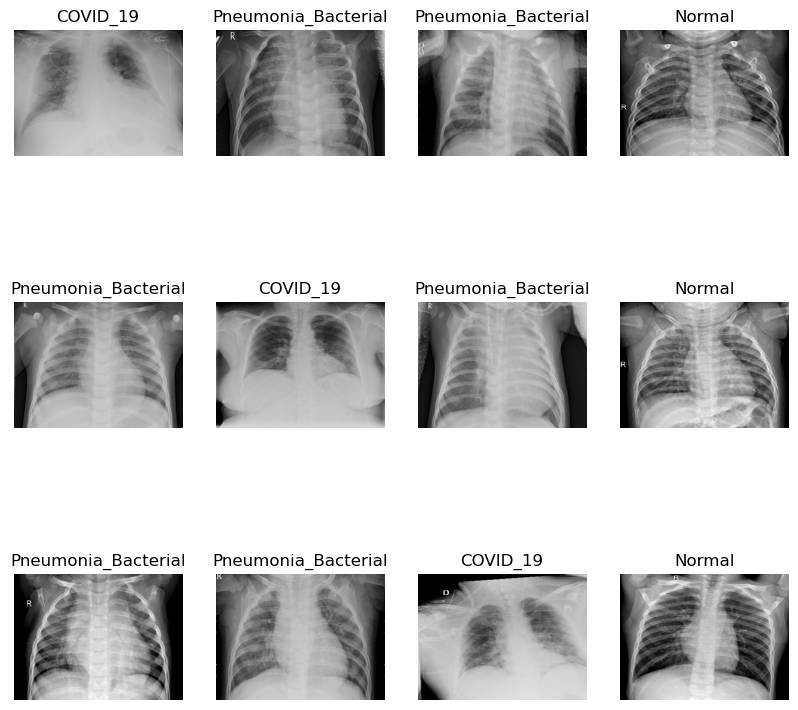

In [91]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.axis("off")
        plt.title(class_names[label_batch[i]])

In [92]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
        
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

In [93]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [96]:
train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 300, 400, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [105]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_HEIGHT, IMAGE_WIDTH),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [106]:
augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [107]:
input_shape = (BATCH_SIZE, IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    augmentation,
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape)

In [108]:
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_17 (Sequential)  (32, 300, 400, 3)         0         
                                                                 
 sequential_18 (Sequential)  (32, 300, 400, 3)         0         
                                                                 
 conv2d_36 (Conv2D)          (32, 298, 398, 32)        896       
                                                                 
 max_pooling2d_36 (MaxPooli  (32, 149, 199, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_37 (Conv2D)          (32, 147, 197, 64)        18496     
                                                                 
 max_pooling2d_37 (MaxPooli  (32, 73, 98, 64)          0         
 ng2D)                                               

In [109]:
model.compile(
    optimizer = 'adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [110]:
history = model.fit(
    train_ds,
    epochs=EPOC,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
60/60 [==============================] - 167s 2s/step - loss: 1.0999 - accuracy: 0.3448 - val_loss: 1.0898 - val_accuracy: 0.3527
Epoch 2/50
60/60 [==============================] - 160s 2s/step - loss: 0.9745 - accuracy: 0.5161 - val_loss: 0.9305 - val_accuracy: 0.6562
Epoch 3/50
60/60 [==============================] - 160s 2s/step - loss: 0.6516 - accuracy: 0.7446 - val_loss: 0.5524 - val_accuracy: 0.7768
Epoch 4/50
60/60 [==============================] - 161s 2s/step - loss: 0.5553 - accuracy: 0.7821 - val_loss: 0.3911 - val_accuracy: 0.8571
Epoch 5/50
60/60 [==============================] - 90s 1s/step - loss: 0.4813 - accuracy: 0.8202 - val_loss: 0.4969 - val_accuracy: 0.8125
Epoch 6/50
60/60 [==============================] - 60s 874ms/step - loss: 0.4345 - accuracy: 0.8371 - val_loss: 0.4567 - val_accuracy: 0.8259
Epoch 7/50
60/60 [==============================] - 61s 867ms/step - loss: 0.3980 - accuracy: 0.8427 - val_loss: 0.3505 - val_accuracy: 0.8750
Epoch 8/50

In [111]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 60}

In [112]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [113]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

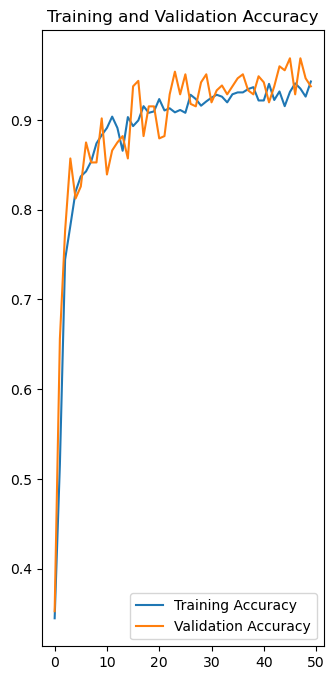

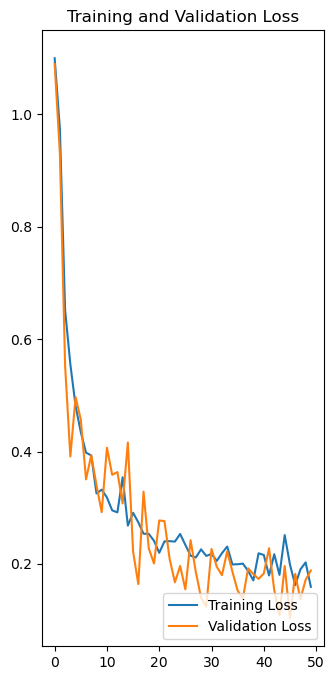

In [114]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOC), acc, label='Training Accuracy')
plt.plot(range(EPOC), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOC), loss, label='Training Loss')
plt.plot(range(EPOC), val_loss, label='Validation Loss')
plt.legend(loc='lower right')
plt.title('Training and Validation Loss')

first image to predict
first image's actual label: COVID_19
1/1 [==============================] - 1s 1s/step
predicted label COVID_19


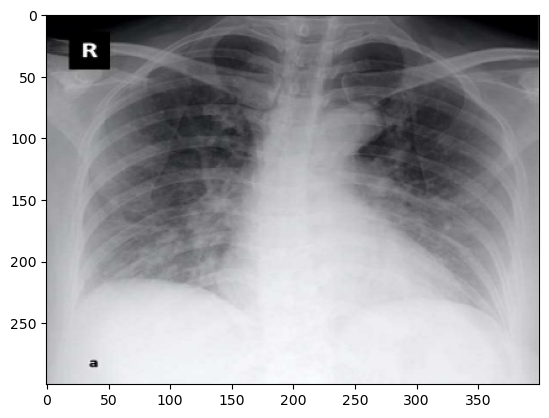

In [115]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0]
    
    print("first image to predict")
    plt.imshow(first_image)
    print("first image's actual label:", class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label", class_names[np.argmax(batch_prediction[0])])

In [116]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 111ms/step


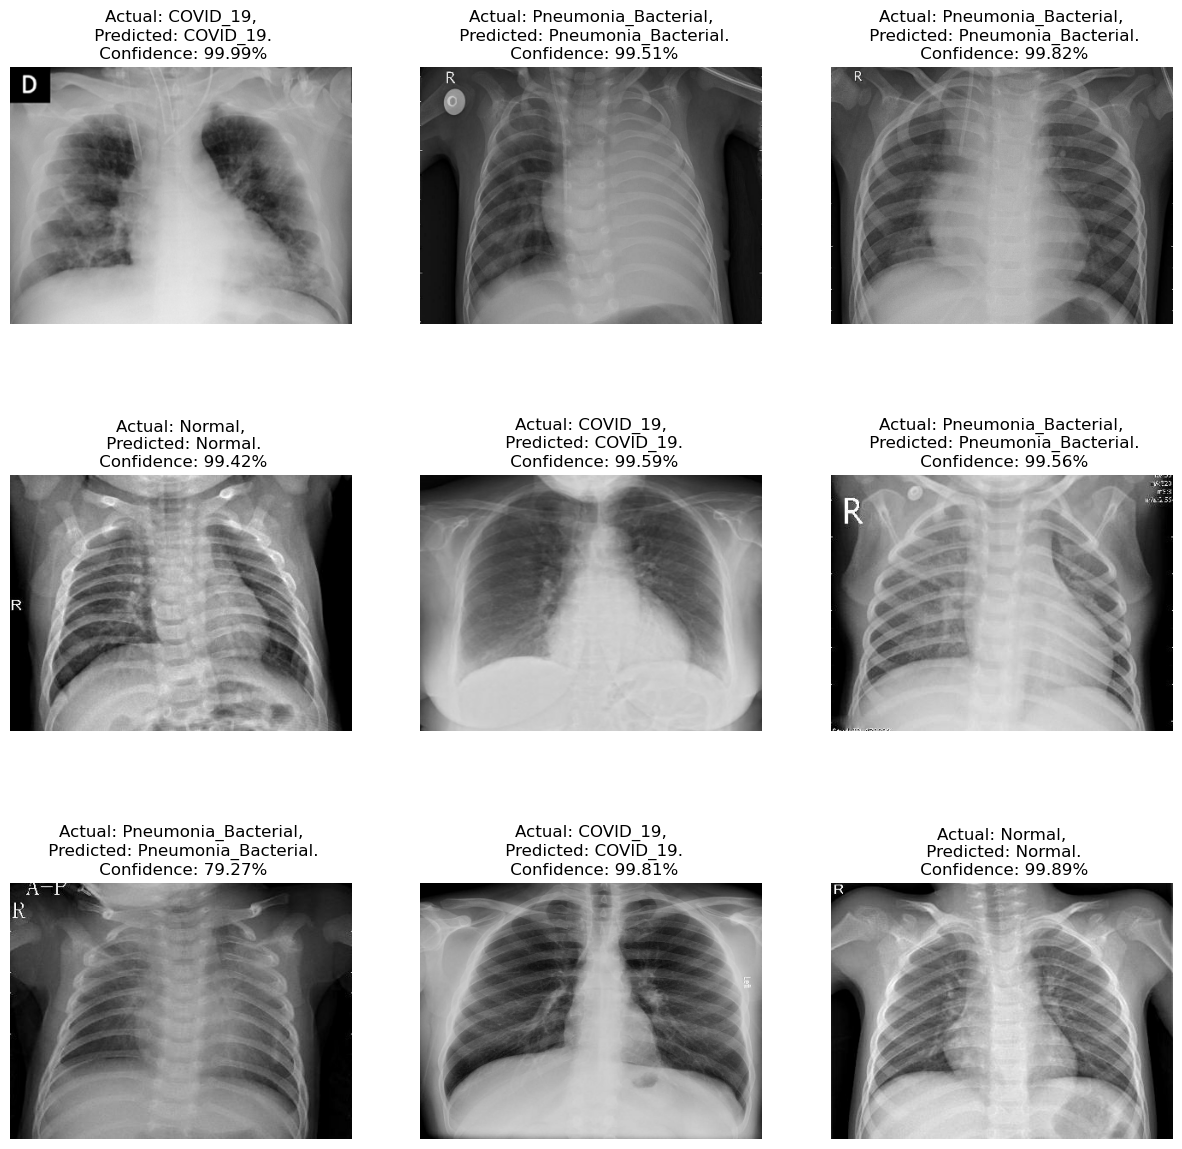

In [118]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [123]:
import os
model_version=max([int(i) for i in os.listdir("../saved_models") + [0]])+1
model.save(f"../saved_models/{model_version}")

INFO:tensorflow:Assets written to: ../saved_models/1\assets


INFO:tensorflow:Assets written to: ../saved_models/1\assets
